Importing image zip and extracting:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 5animals.zip to 5animals.zip


In [ ]:
import zipfile
import os

# name of the image set zip
zip_path = "5animals.zip"
# destination folder for extraction
extract_to = "ImageFolder"

os.makedirs(extract_to, exist_ok=True)

# extract the zip of images
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Processing images and making directories:

In [ ]:
from PIL import Image

# function to load and process images from the set
def load_images(folder):
    images = []
    file_names = []
    for file_name in sorted(os.listdir(folder)):
        # only these 3 image types
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder, file_name)
            try:
                # add the image
                image = Image.open(image_path).convert('RGB')
                images.append(image)
                file_names.append(file_name)
            except:
                print(f"Could not load the image: {file_name}")
    return images, file_names

# load the images from the extracted zip
image_folder = extract_to
images, file_names = load_images(image_folder)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
import cv2
import numpy as np

# folder where images will are saved
save_folder = "Images"
os.makedirs(save_folder, exist_ok=True)

# adding images into the folder
for image, file_name in zip(images, file_names):
    image_np = np.array(image)
    # rgb to bgr conversion
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    save_path = os.path.join(save_folder, file_name)
    # save the image
    cv2.imwrite(save_path, image_bgr)

Importing libraries:

In [ ]:
import cv2                                                                # for image writing and reading
from tensorflow.keras.models import load_model, Model                     # for deep learning models
from sklearn.cluster import KMeans                                        # for K-means clustering
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input   # for transfer learning (VGG16 model)
from tensorflow.keras.preprocessing import image                          # for image operations
from tensorflow.keras.utils import plot_model                             # for plotting the model
import matplotlib.image as mpimg                                          # for plotting images
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score          # for silhouette score evaluation
from tabulate import tabulate                                             # for displaying results
import torch

%matplotlib inline

# use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Defining functions:

In [ ]:
# function to create a dictionary of the resized images
def create_file_dict(path_to_files, size):
    fn_images = []
    # store all image files names
    files = [file for file in os.listdir(path_to_files)]
    for file in files:
        # create the correct file path
        image_path = os.path.join(path_to_files, file)
        # resize each image
        image = cv2.resize(cv2.imread(image_path), size)
        # each image to a variable
        fn_images.append([file, image])
    # returning the dictionary of all the images and their respective names
    return dict(fn_images)

In [ ]:
# function to build feature extractor model using pretrained VGG16 model
def build_model(layer='fc2'):

    # load VGG model trained with imagenet dataset
    VGG_model = VGG16(weights='imagenet', include_top=True)
    # construct a new model with same VGG input and output taken from fc2
    model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer(layer).output)
    return model

In [ ]:
# function to extract feature vector from an image (helper function)
def extract_feature_vector(image_array, model):
    if image_array.shape[2] == 1:
      # repeat grayscale pixel values to 3 color channels
      image_array = image_array.repeat(3, axis=2)

    # add a batch dimension to make the shape (1, 224, 224, 3) — for Keras model
    arr4d = np.expand_dims(image_array, axis=0)
    arr4d_pp = preprocess_input(arr4d)
    # feed the image into the model and return the feature vector
    return model.predict(arr4d_pp)[0,:]

In [ ]:
# function to extract features from all images
def extract_feature_vectors(images_dict, model):
    feature_vector = {}
    # loop over each image in the image dictionary
    for fn, image in images_dict.items():
      # calling helper function to extract the features from current image
      feature_vector[fn] = extract_feature_vector(image, model)
    return feature_vector

Building the model:

In [ ]:
# call the build function
model = build_model()

# print the model summary
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

Extracting feature vectors:

In [ ]:
# get the path to the images
image_path = save_folder

# create a dictionary of the images (and resize)
image_dict = create_file_dict(path_to_files = image_path ,size = (224, 224))

# extract feature vectors from images using the model
extracted_feature_vector = extract_feature_vectors(image_dict, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

Determine optimal number of clusters using elbow method:

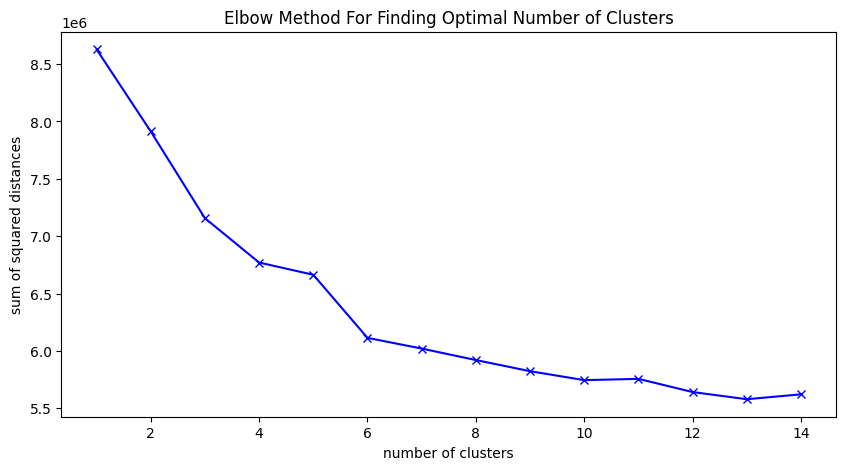

In [ ]:
# create a list of the feature vectors
images = list(extracted_feature_vector.values())

sum_of_squared_distances = []

# range of clusters
K = range(1, 15)

# loop over cluster range
for k in K:
    # initialize Kmeans model
    kmeans_model = KMeans(n_clusters=k)
    # run clustering with the model
    kmeans_model = kmeans_model.fit(images)
    # store sum of squared distances from each point to its assigned cluster center
    sum_of_squared_distances.append(kmeans_model.inertia_)

# plot the elbow method
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Finding Optimal Number of Clusters')
plt.show()

Clustering using optimal number of clusters:

In [ ]:
# optimal number of clusters from above elbow method graph (matches number of animals)
optimal_n_clusters = 5
# initialize Kmeans model with optimal clusters
kmeans_model = KMeans(n_clusters=optimal_n_clusters, init='k-means++')
# fit the clustering object to the dataset
kmeans_model.fit(images)
# predicting clusters for each image in the dataset
y_kmeans = kmeans_model.predict(images)
file_names = list(image_dict.keys())

Creating cluster directories:

In [ ]:
# path for storing clusters
cluster_path = image_path
# path to image dataset
path_to_files = image_path

# creating each cluster folder
for c in range(0,optimal_n_clusters):
    if not os.path.exists('Cluster_'+str(c)):
        os.mkdir('Cluster_'+str(c))

# storing images in correct clusters
for file_name, cluster in zip(file_names, y_kmeans):
    # create the correct file path
    image_path = os.path.join(path_to_files, file_name)

    # check if the file exists before reading
    if os.path.exists(image_path):
        image = cv2.imread(image_path)

        if image is not None:
            # write the image into the cluster directory
            cv2.imwrite(os.path.join('Cluster_'+str(cluster), file_name), image)
        else:
            print(f"Failed to read image: {image_path}")
    else:
        print(f"Image file not found: {image_path}")

Evaluating performance using silhouette scores:

For number of clusters = 5 The average silhouette score is : 0.12903364


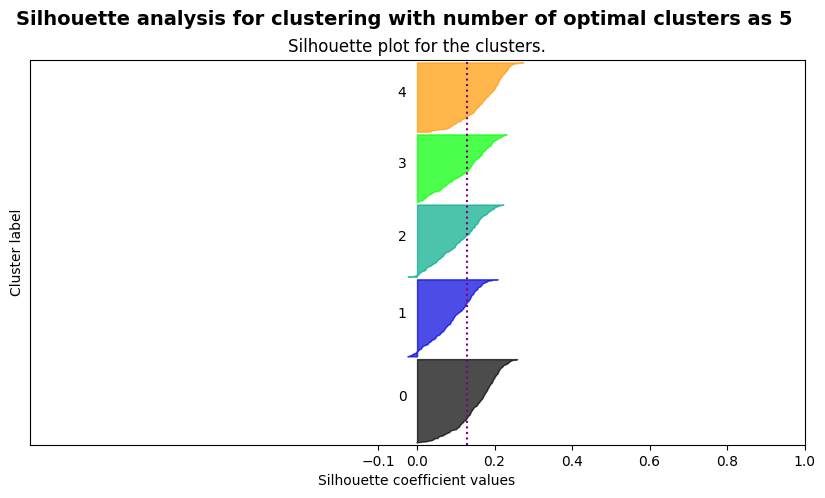

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim([-1, 1])
ax.set_ylim([0, len(images) + (optimal_n_clusters + 1) * 10])

# compute the silhouette scores for each image
sample_silhouette_values = silhouette_samples(images, y_kmeans)
# compute the average silhouette score
silhouette_average = silhouette_score(images, y_kmeans)

y_lower = 10
# loop over each image in the cluster
for i in range(optimal_n_clusters):
  # aggregate the silhouette scores for samples belonging to cluster i and sort them
  ith_cluster_silhouette_values = \
      sample_silhouette_values[y_kmeans == i]

  # sort each cluster score
  ith_cluster_silhouette_values.sort()

  # setting limit for each cluster in y-axis
  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  # setting color for each cluster's silhouette coefficients
  color = cm.nipy_spectral(float(i) / optimal_n_clusters)
  ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

  # label the silhouette plots with their cluster numbers at the middle
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # compute the new y_lower for next plot
  y_lower = y_upper + 10

ax.set_title("Silhouette plot for the clusters.")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_average, color="purple", linestyle=":")

ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for clustering "
                  "with number of optimal clusters as %d" % optimal_n_clusters),
                 fontsize=14, fontweight='bold');

print("For number of clusters =", optimal_n_clusters,
          "The average silhouette score is :", silhouette_average)

Analyzing cluster compositions:

Cluster-wise Accuracy Report:

Cluster 3:
  Total images: 267
  Most common animal: fox (244 images)
  Accuracy: 91.39%



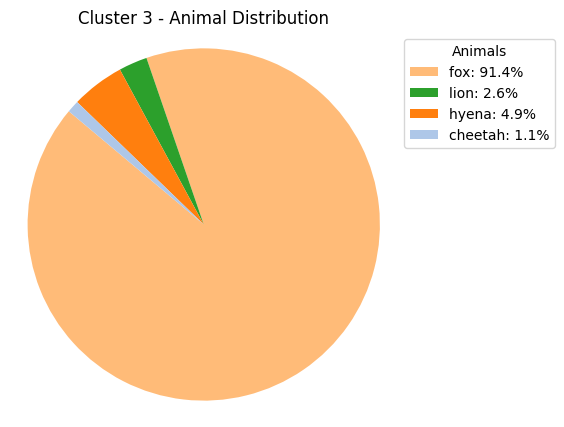

Cluster 0:
  Total images: 329
  Most common animal: cheetah (327 images)
  Accuracy: 99.39%



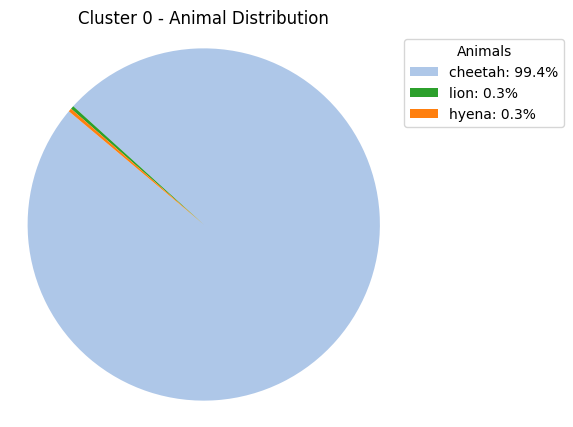

Cluster 1:
  Total images: 305
  Most common animal: hyena (287 images)
  Accuracy: 94.10%



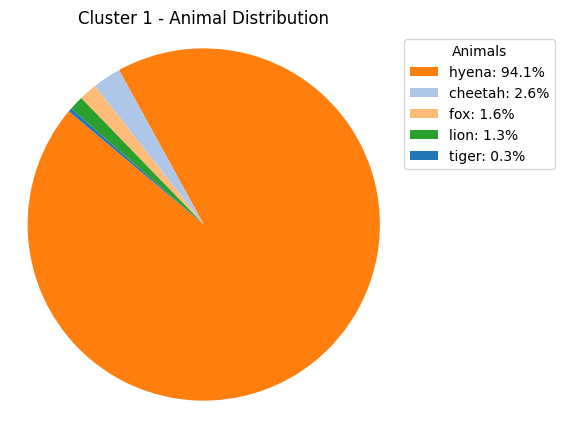

Cluster 2:
  Total images: 285
  Most common animal: lion (276 images)
  Accuracy: 96.84%



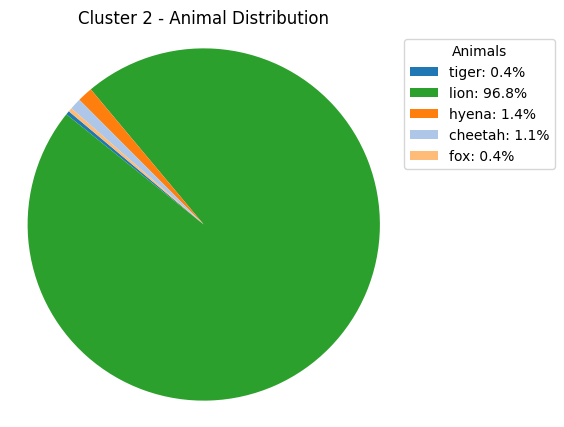

Cluster 4:
  Total images: 274
  Most common animal: tiger (267 images)
  Accuracy: 97.45%



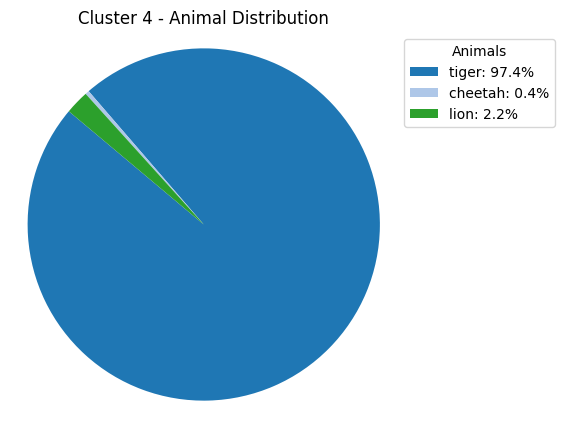

Overall Clustering Accuracy: 95.83%


In [ ]:
# imports
from collections import defaultdict, Counter

# extracting the animal name from the file name (implicit labels)
def extract_animal_name(filename):
    return filename.split(' (')[0].lower()

# grouping the file names by cluster
cluster_to_filenames = defaultdict(list)
filename_to_cluster = dict(zip(file_names, y_kmeans))

for filename, cluster in filename_to_cluster.items():
    cluster_to_filenames[cluster].append(filename)

cluster_accuracies = []
print("Cluster-wise Accuracy Report:\n")


# gets list of all unique animals
all_animal_names = set()
for filenames in cluster_to_filenames.values():
    for filename in filenames:
        animal_name = extract_animal_name(filename)
        all_animal_names.add(animal_name)


# creating a colour map for the animals so that the chart colours are all consistent
num_animals = len(all_animal_names)
colours = cm.tab20.colors
colour_map = {animal: colours[i % len(colours)] for i, animal in enumerate(all_animal_names)}

# loop over all clusters
for cluster_id, filenames in cluster_to_filenames.items():
    animal_counts = Counter(extract_animal_name(fn) for fn in filenames)
    total = len(filenames)
    most_common_animal, count = animal_counts.most_common(1)[0]
    accuracy = count / total if total > 0 else 0
    cluster_accuracies.append(accuracy)

    # print out results of each cluster
    print(f"Cluster {cluster_id}:")
    print(f"  Total images: {total}")
    print(f"  Most common animal: {most_common_animal} ({count} images)")
    print(f"  Accuracy: {accuracy:.2%}\n")

    # labels and sizes
    labels = list(animal_counts.keys())
    sizes = list(animal_counts.values())

    # assign colours for each animal
    cluster_colors = [colour_map[animal] for animal in labels]

    # plot pie chart
    plt.figure(figsize=(5, 5))
    wedges, texts = plt.pie(sizes, colors=cluster_colors, startangle=140)
    plt.axis('equal')
    plt.title(f"Cluster {cluster_id} - Animal Distribution")

    # create legend with animal names and percentages
    plt.legend(
        [f"{label}: {size / total * 100:.1f}%" for label, size in zip(labels, sizes)],
        loc='best',
        title="Animals",
        bbox_to_anchor=(1, 1)
    )
    plt.show()

# calculate overall accuracy
overall_accuracy = np.mean(cluster_accuracies)
print(f"Overall Clustering Accuracy: {overall_accuracy:.2%}")


Plotting sample images from each cluster:

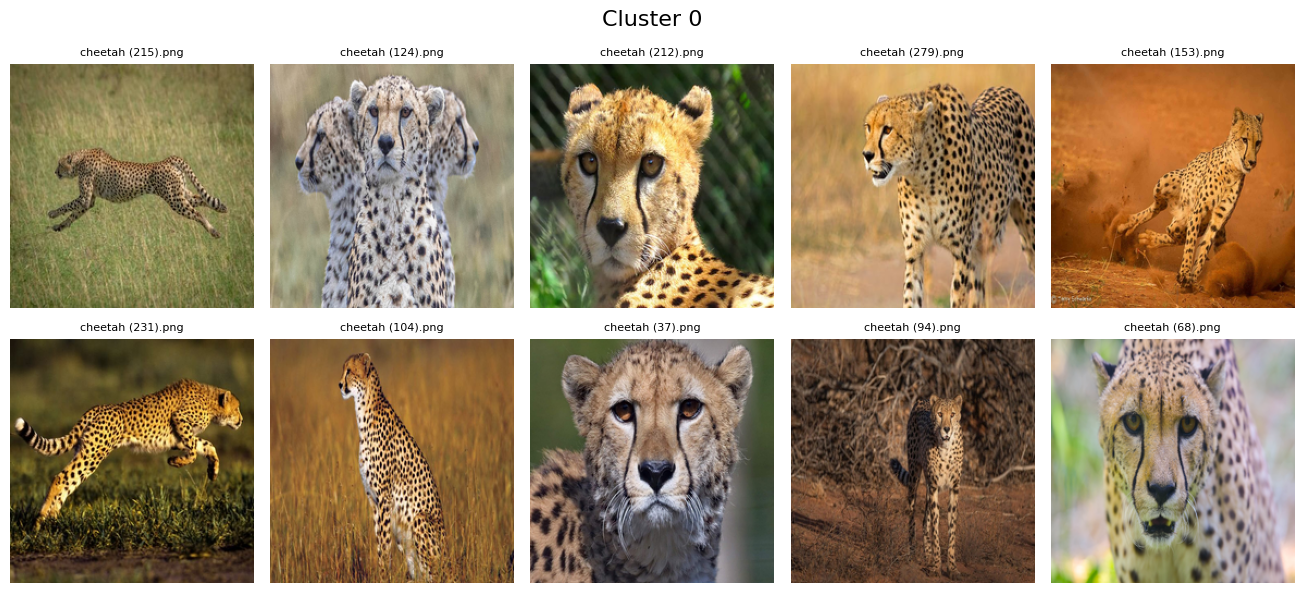

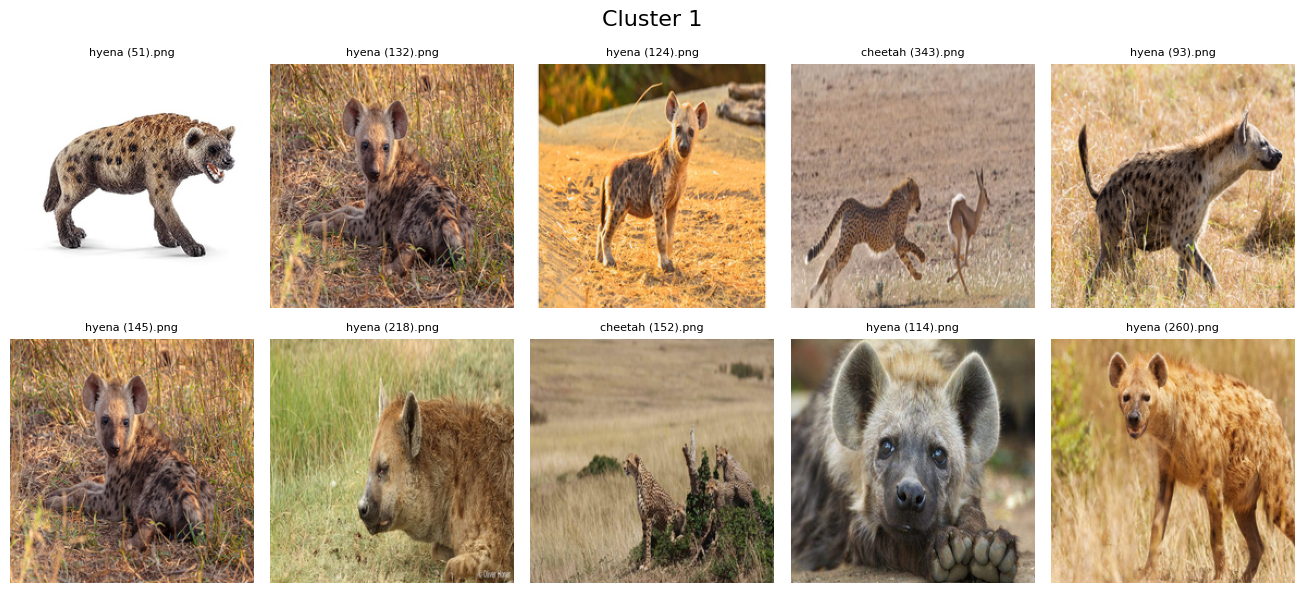

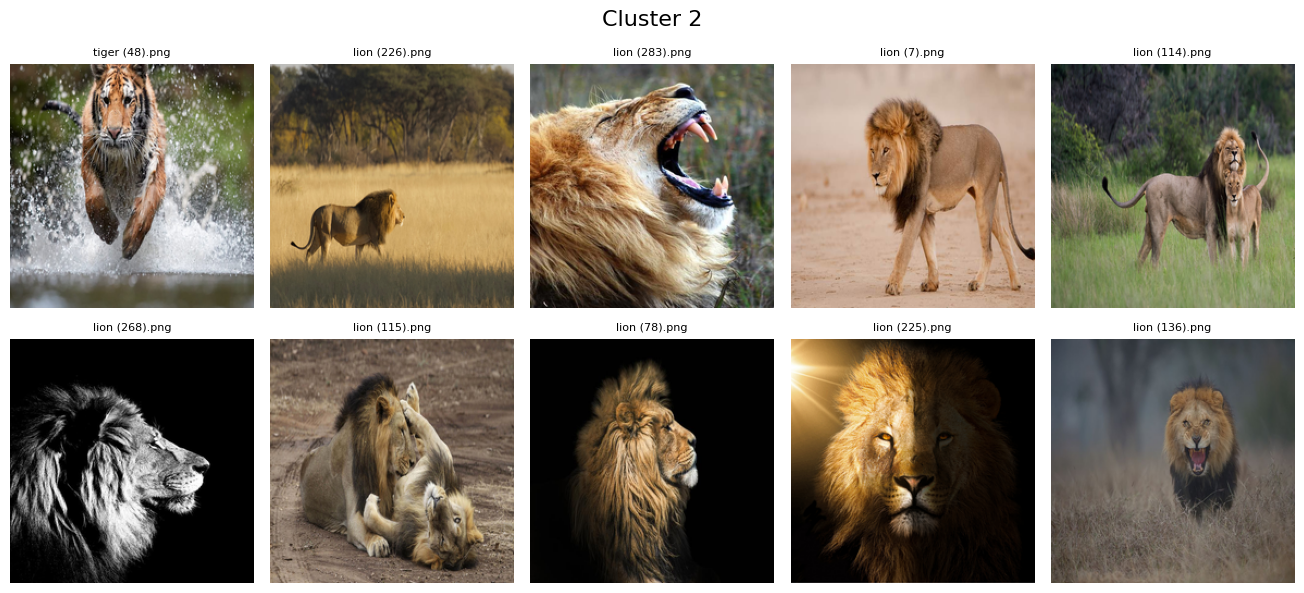

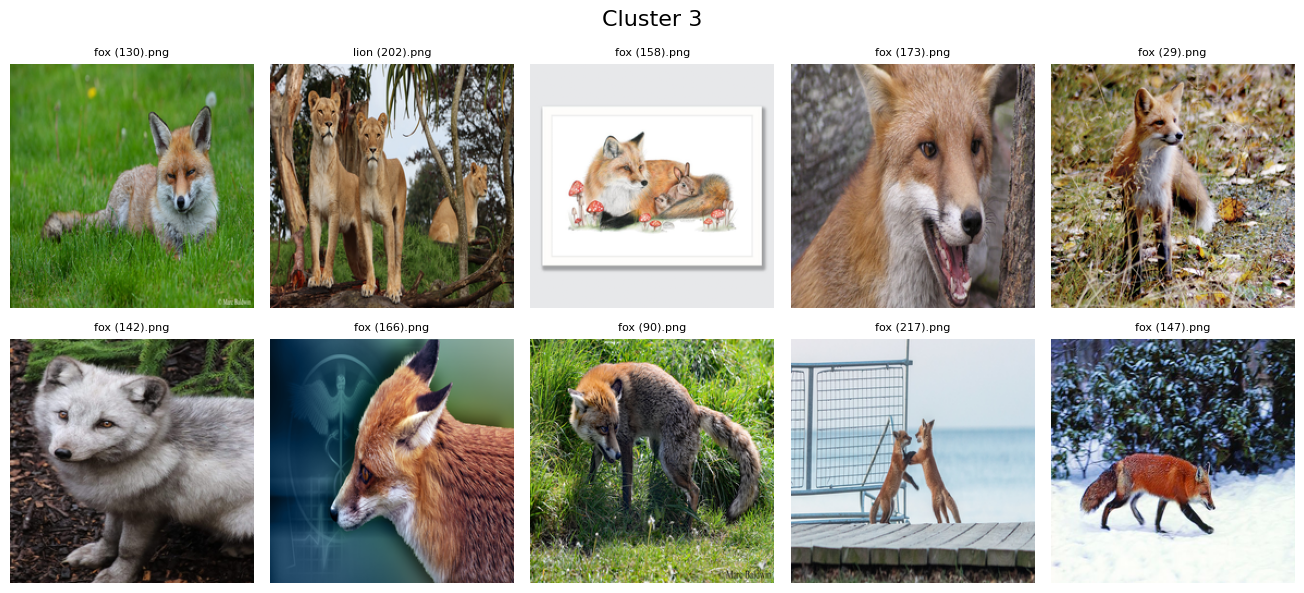

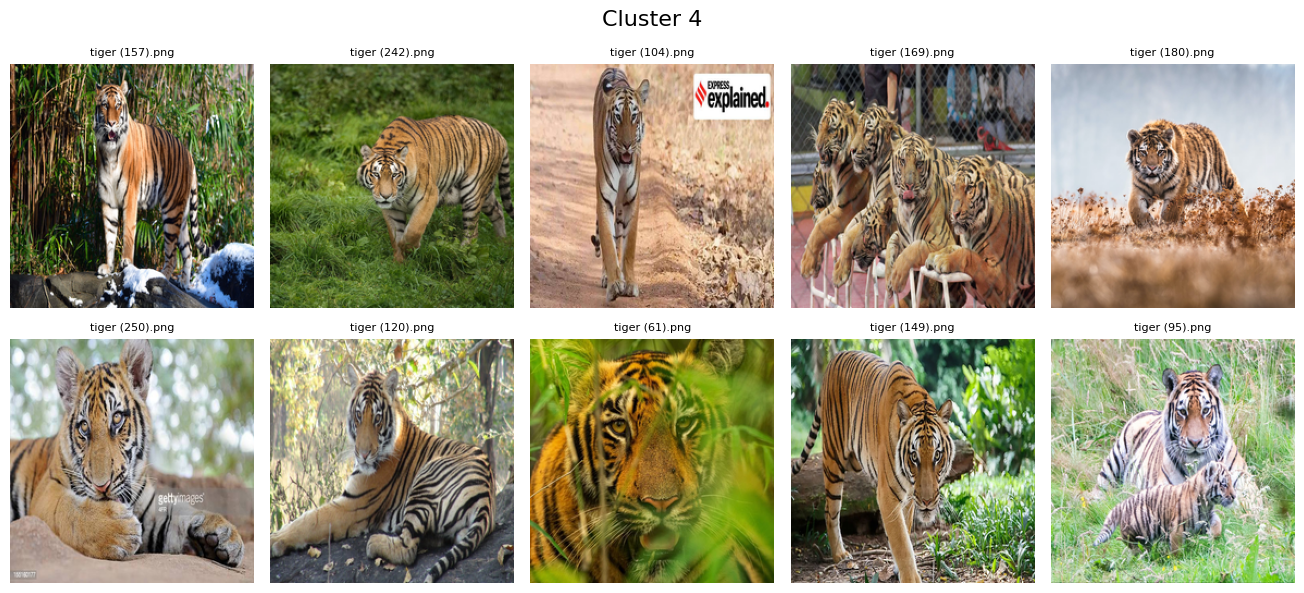

In [ ]:
for cluster_num in range(optimal_n_clusters):
    cluster_path = f"Cluster_{cluster_num}"
    images = [file for file in os.listdir(cluster_path) if file.endswith(('.png', '.jpg', '.jpeg'))]

    rows, cols = 2, 5
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle(f"Cluster {cluster_num}", fontsize=16)

    for cnt, data in enumerate(images[:10]):
        if cnt >= rows * cols:
            break

        ax = fig.add_subplot(rows, cols, cnt + 1)
        img = mpimg.imread(os.path.join(cluster_path, data))
        ax.imshow(img)
        ax.set_title(os.path.basename(data), fontsize=8)
        ax.axis("off")
        plt.tight_layout(pad=3.0)

    plt.tight_layout()
    plt.show()
